In [1]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings('ignore')

In [2]:
DATA_DIR_BASELINE = os.path.join('gait_entropy_dataset_timewindow_20.csv')
gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['fuzzy_entropy','spectral_entropy','dispersion_entropy','slope_entropy','label'])
# gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['slope_entropy','label'])
# gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['approximate_entropy','sample_entrpy','fuzzy_entropy','permutation_entropy','spectral_entropy','increment_entropy','slope_entropy','label'])
gait_entropy_dataset

,fuzzy_entropy,spectral_entropy,dispersion_entropy,slope_entropy,label
0,0.002216,0.306904,2.059229,-0.000000,old_general
1,0.000934,0.305605,1.822457,-0.000000,old_general
2,0.001897,0.305357,2.114308,-0.000000,old_general
3,0.008119,0.307437,1.864237,0.297472,old_general
4,0.000611,0.305790,1.867880,-0.000000,old_general
...,...,...,...,...,...
426,0.000717,0.307542,1.809158,-0.000000,young_general
427,0.001571,0.304924,1.809158,-0.000000,young_general
428,0.001554,0.305740,1.731026,-0.000000,young_general
429,0.001616,0.305419,1.867880,-0.000000,young_general


In [3]:
gait_entropy_dataset = gait_entropy_dataset[gait_entropy_dataset['label']!='young_general']
gait_entropy_dataset

,fuzzy_entropy,spectral_entropy,dispersion_entropy,slope_entropy,label
0,0.002216,0.306904,2.059229,-0.000000,old_general
1,0.000934,0.305605,1.822457,-0.000000,old_general
2,0.001897,0.305357,2.114308,-0.000000,old_general
3,0.008119,0.307437,1.864237,0.297472,old_general
4,0.000611,0.305790,1.867880,-0.000000,old_general
...,...,...,...,...,...
238,0.014112,0.309014,2.132192,0.774243,old_parkinson
239,0.006096,0.305294,2.114308,-0.000000,old_parkinson
240,0.004368,0.305951,1.986267,-0.000000,old_parkinson
241,0.022088,0.306188,2.159732,0.953014,old_parkinson


In [4]:
# pre-processing dataset
mapping = {'old_general':0, 'old_parkinson':1}
gait_entropy = gait_entropy_dataset
gait_entropy['label'] = gait_entropy['label'].map(mapping)
gait_entropy

,fuzzy_entropy,spectral_entropy,dispersion_entropy,slope_entropy,label
0,0.002216,0.306904,2.059229,-0.000000,0
1,0.000934,0.305605,1.822457,-0.000000,0
2,0.001897,0.305357,2.114308,-0.000000,0
3,0.008119,0.307437,1.864237,0.297472,0
4,0.000611,0.305790,1.867880,-0.000000,0
...,...,...,...,...,...
238,0.014112,0.309014,2.132192,0.774243,1
239,0.006096,0.305294,2.114308,-0.000000,1
240,0.004368,0.305951,1.986267,-0.000000,1
241,0.022088,0.306188,2.159732,0.953014,1


train_recall    0.872776
test_recall     0.699824
train_f1        0.892675
test_f1         0.732267
train_acc       0.945882
test_acc        0.864840
cv_score        0.865371
dtype: float64


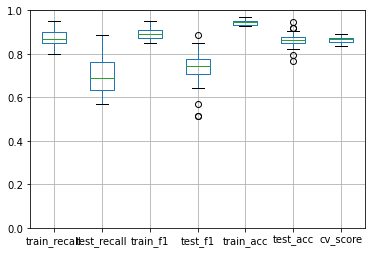

In [7]:
train_recall_lr = []
test_recall_lr = []

train_f1_lr = []
test_f1_lr = []

train_acc_lr = []
test_acc_lr = []

cv_score = []
auc_score = []

for i in range(30):
    gait_label_0 = gait_entropy[gait_entropy['label']==0]
    gait_label_1 = gait_entropy[gait_entropy['label']==1]

    gait_label_0_train = gait_label_0
    gait_label_1_train = gait_label_1

    gait_baseline_model_dataset = pd.concat([gait_label_0_train, gait_label_1_train])

    gait_baseline_model_dataset = shuffle(gait_baseline_model_dataset).reset_index(drop=True) # disrupt the order

    X = gait_baseline_model_dataset.iloc[:, 0:-1]
    Y = gait_baseline_model_dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

    # normalisation
    X_scaler = StandardScaler().fit(X_train)
    standardized_X_train = X_scaler.transform(X_train)
    standardized_X_test = X_scaler.transform(X_test)

    # Initialising the model and training
    # linear_svc = SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=10).fit(X_train, y_train)    
    # forest = RandomForestClassifier(criterion = 'entropy',oob_score=True,n_estimators=1, max_depth=1, min_samples_split=2,max_features='auto',random_state=10).fit(X_train, y_train)    
    forest = RandomForestClassifier(n_estimators=10, max_depth=4,min_samples_leaf=2,min_samples_split=2,max_features='auto').fit(X_train, y_train)    

    # prediction and results
    training = forest.predict(X_train)
    testing=forest.predict(X_test)

    train_recall = recall_score(training,y_train)
    train_f1 = f1_score(training,y_train)
    train_accuracy = accuracy_score(training,y_train)

    test_recall = recall_score(testing,y_test)
    test_f1 = f1_score(testing,y_test)
    test_accuracy = accuracy_score(testing,y_test)

    train_recall_i = train_recall
    test_recall_i = test_recall

    train_f1_i = train_f1
    test_f1_i = test_f1

    train_acc_i = train_accuracy
    test_acc_i = test_accuracy

    train_recall_lr.append(train_recall_i)
    test_recall_lr.append(test_recall_i)
    train_f1_lr.append(train_f1_i)
    test_f1_lr.append(test_f1_i)
    train_acc_lr.append(train_acc_i)
    test_acc_lr.append(test_acc_i)

    cv_scores_i = cross_val_score(forest, X, Y, cv=5)
    cv_score.append(cv_scores_i.mean())

    auc_score_i = average_precision_score(testing,y_test)
    auc_score.append(auc_score_i)

    # print(testing)
    # print(y_test)

train_recall_lr = pd.DataFrame(train_recall_lr, columns=['train_recall'])
test_recall_lr = pd.DataFrame(test_recall_lr, columns=['test_recall'])
train_f1_lr = pd.DataFrame(train_f1_lr, columns=['train_f1'])
test_f1_lr = pd.DataFrame(test_f1_lr, columns = ['test_f1'])
train_acc_lr = pd.DataFrame(train_acc_lr, columns=['train_acc'])
test_acc_lr = pd.DataFrame(test_acc_lr, columns=['test_acc'])
cv_score = pd.DataFrame(cv_score, columns=['cv_score'])
auc_score = pd.DataFrame(auc_score, columns=['auc_score'])
all_events_recall_logic_reg = pd.concat([train_recall_lr, test_recall_lr, train_f1_lr, test_f1_lr,train_acc_lr,test_acc_lr,cv_score],axis=1)
# all_events_recall_logic_reg = pd.concat([cv_score],axis=1)
# all_events_recall_logic_reg.to_csv('result_baseline_lr.csv')
all_events_recall_logic_reg.boxplot()  
plt.ylim(0,1) 
print(all_events_recall_logic_reg.mean())

In [ ]:
all_events_recall_logic_reg.to_csv('result_entropy_rf.csv')

In [ ]:
all_events_recall_logic_reg